
# Global fit to all three K2 campaign lightcurves

and ASASSN!

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# subsub K2

In [2]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [3]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

Read in the ASASSN data.

In [7]:
usecols = ['HJD', 'flux(mJy)', 'flux_err', 'Filter']
df_ASASSN = pd.read_csv('../data/raw/ASASSN/S1063_ASASSN_20190123.csv', usecols=usecols)

# Tidy up the dataframe
df_ASASSN = df_ASASSN[df_ASASSN.flux_err!=99.990].reset_index(drop=True)
df_ASASSN.rename(columns={'flux(mJy)':'flux', 'HJD':'time'},inplace=True)
df_ASASSN['time'] = df_ASASSN['time'] - 2454833.0

In [9]:
# Focus on one filter at a time...
filt = 'V'
df_ASASSN = df_ASASSN[df_ASASSN.Filter == filt].reset_index(drop=True)[['time', 'flux', 'flux_err']]
const = np.percentile(df_ASASSN.flux, 80)

In [10]:
df_ASASSN.shape

(758, 3)

In [11]:
# Normalize
df_ASASSN['flux'] /=const
df_ASASSN['flux_err'] /=const

# drop outliers
good_mask = (df_ASASSN.flux > 0.7) & (df_ASASSN.time < 3500)
df_ASASSN = df_ASASSN[good_mask].reset_index(drop=True)

In [12]:
df_ASASSN.shape

(724, 3)

In [5]:
df = pd.concat([dfC16, dfC18], ignore_index=True)
df['flux'] = df.flux / np.percentile(df.flux, 98)
df['flux_err'] = df.flux *0.01

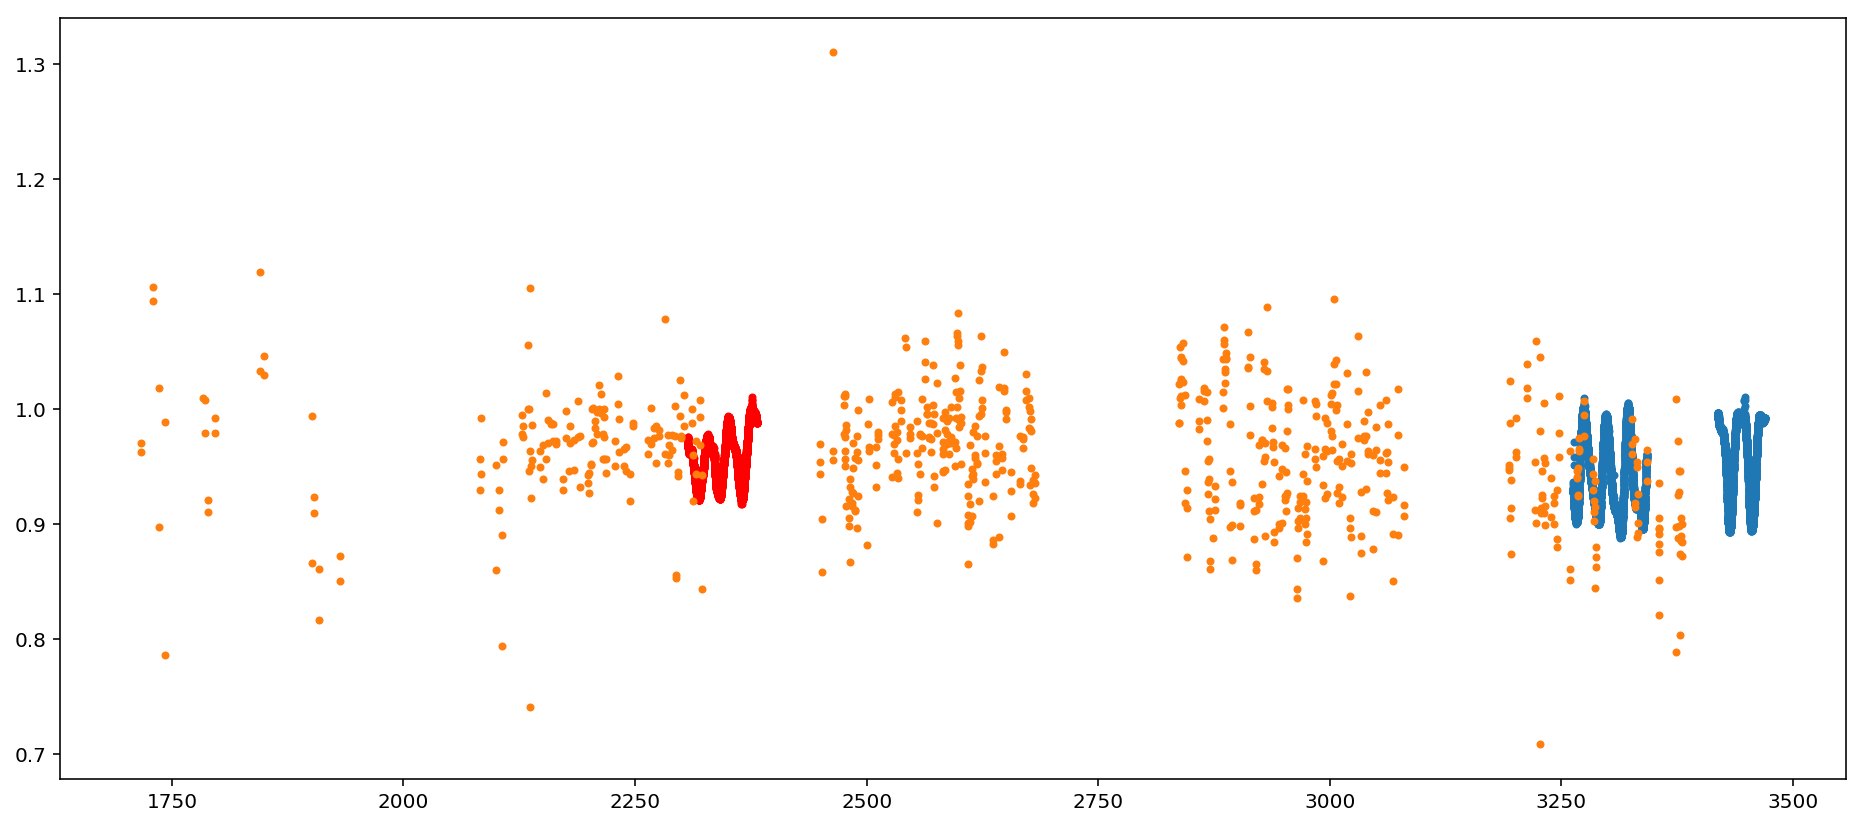

In [6]:
plt.figure(figsize=(16, 7))
plt.plot(df.time, df.flux, '.')
plt.plot(dfC05.time, dfC05.flux/ np.percentile(dfC05.flux, 98), 'r.')
plt.plot(df_ASASSN.time, df_ASASSN.flux, '.')
#plt.xlim(2457000, 2458000+400)
#plt.ylim(0.8, 1.2)

(0.8, 1.2)

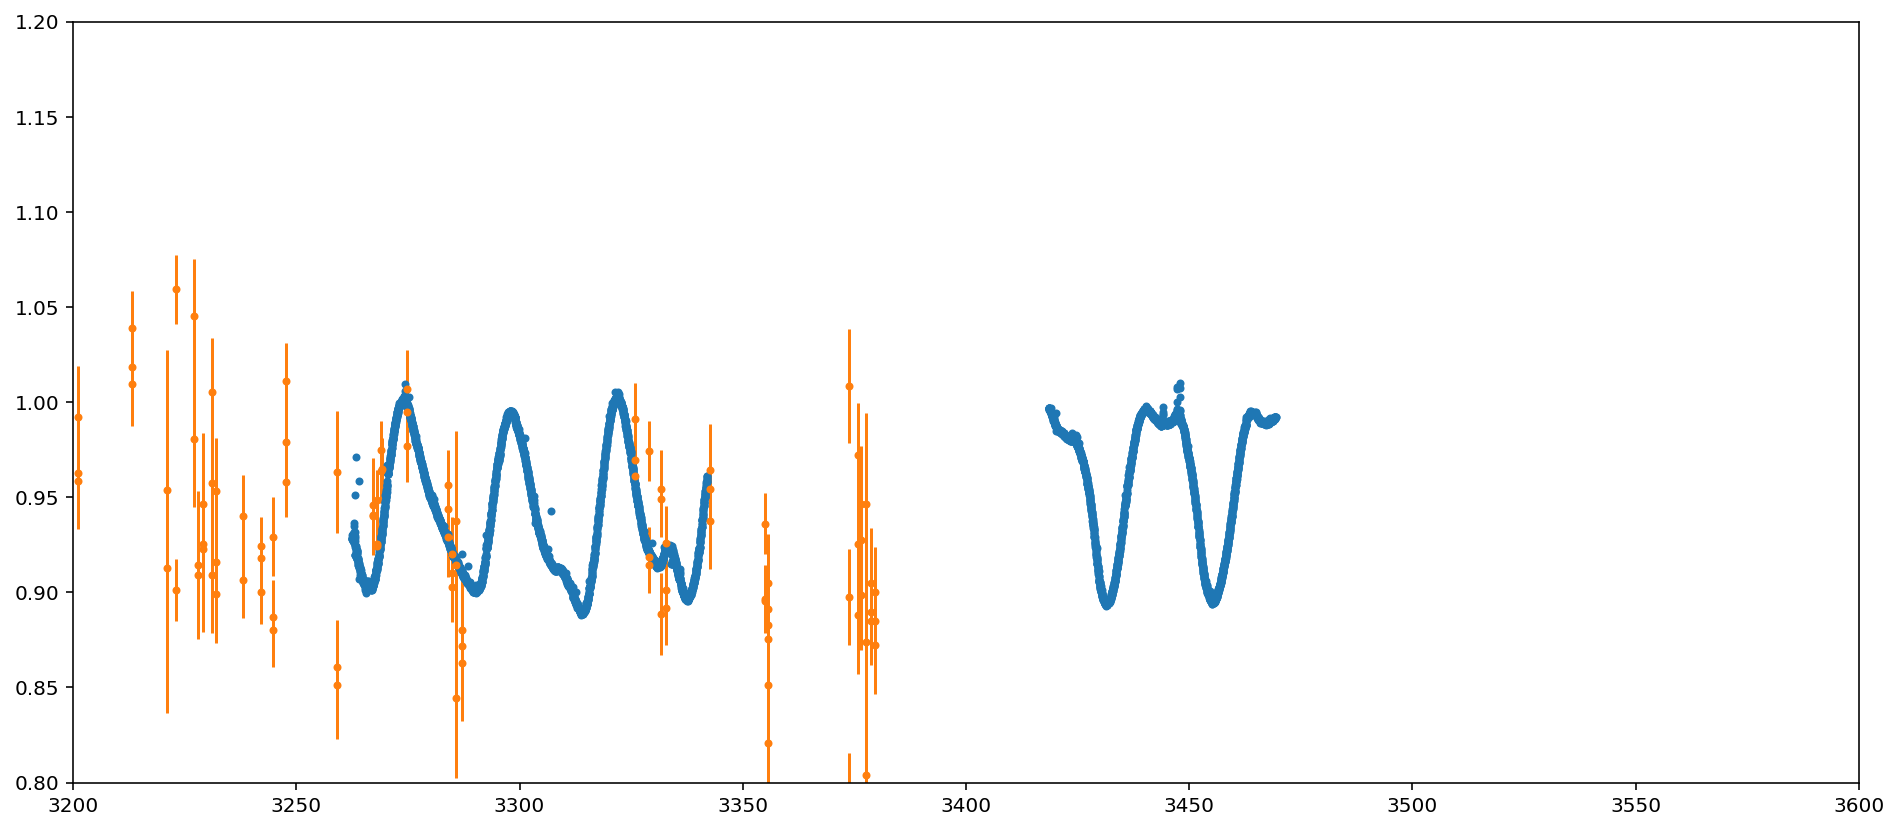

In [7]:
plt.figure(figsize=(16, 7))
plt.plot(df.time, df.flux, '.')
plt.errorbar(df_ASASSN.time, df_ASASSN.flux, df_ASASSN.flux_err,fmt='.')
plt.xlim(3200, 3200+400)
plt.ylim(0.8, 1.2)

Nice

In [8]:
#df = pd.concat([df, df_ASASSN], ignore_index=True)

In [9]:
df_subset = df.sort_values('time').reset_index(drop=True)

In [10]:
t = df_subset.time.values
y = df_subset.flux
yerr = df_subset.flux_err*2.0

<ErrorbarContainer object of 3 artists>

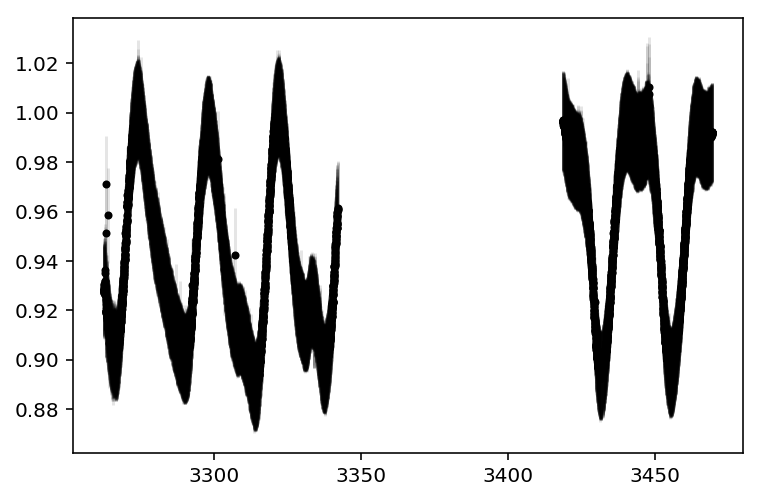

In [11]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)

In [12]:
2.0 * np.pi / 23.5, 2.0 * np.pi / 13

(0.26736958753955686, 0.483321946706122)

In [13]:
import celerite
from celerite import terms

# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [14]:
%%time
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 18161.787016677117
CPU times: user 2.59 ms, sys: 1.06 ms, total: 3.66 ms
Wall time: 2.79 ms


Text(0, 0.5, 'y')

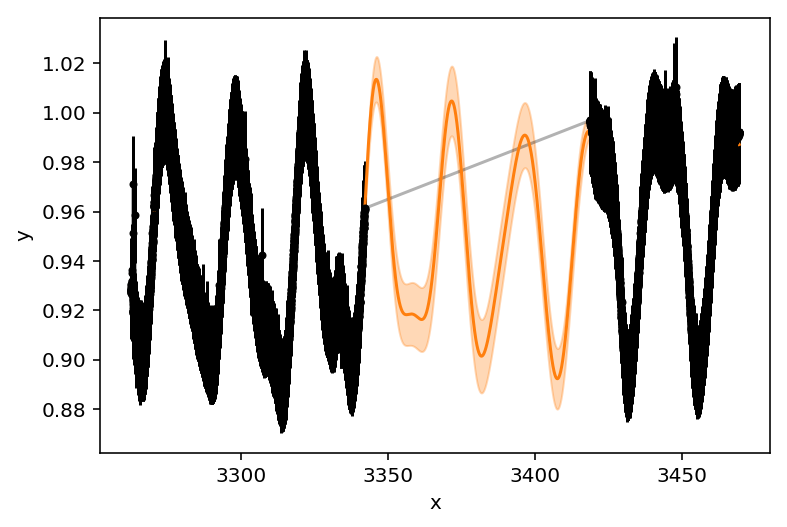

In [15]:
x = np.arange(df_subset.time.iloc[0], df_subset.time.iloc[-1], 1.0/24/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

(3272, 3273)

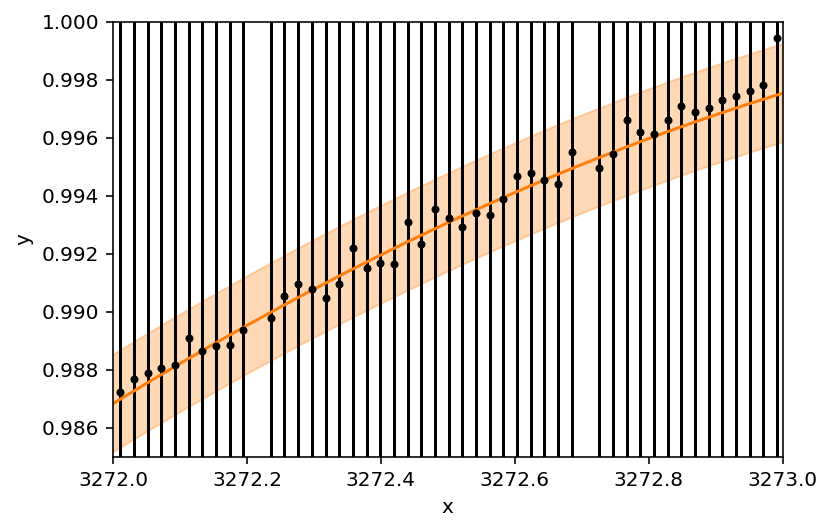

In [16]:
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0.985, 1.0)
plt.xlim(3272, 3273)

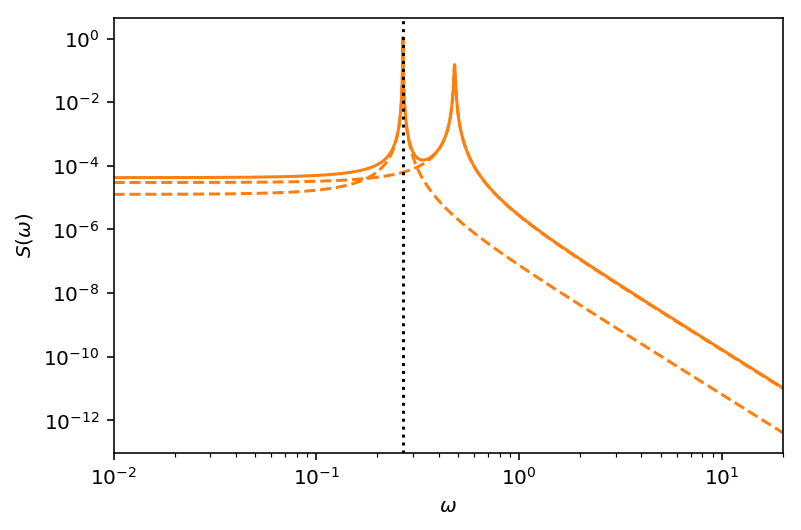

In [17]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [18]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -18203.776398193422
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00363798,  0.07457857, -0.00291038, -0.00291038,  0.01928129])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 36
   status: 0
  success: True
        x: array([-12.48283183,  -0.62458243,  -8.1265637 ,   2.80414327,
        -1.34893437])


In [19]:
np.pi*2/10**-0.8290087063581993, np.pi*2/10**-1.3457165415991024

(42.382695572041094, 139.28245400025708)

In [20]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -12.482831826156989),
             ('kernel:terms[0]:log_omega0', -0.6245824324041052),
             ('kernel:terms[1]:log_S0', -8.126563700263786),
             ('kernel:terms[1]:log_Q', 2.8041432702170175),
             ('kernel:terms[1]:log_omega0', -1.3489343703150651)])

In [21]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

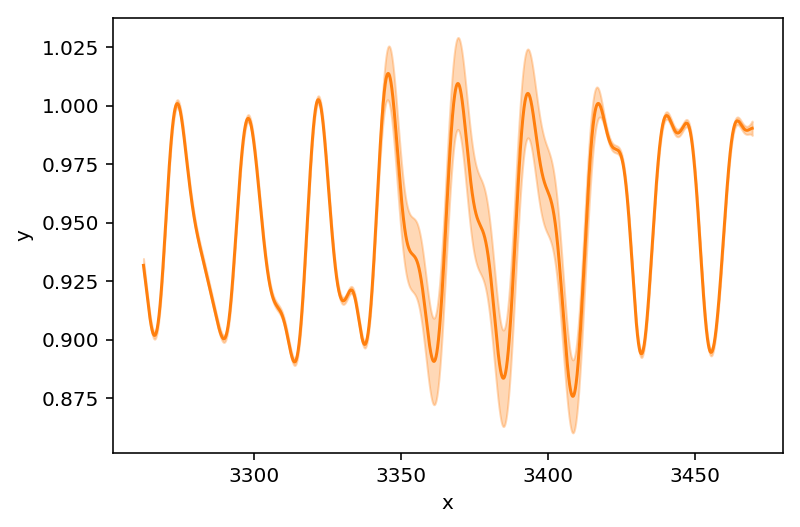

In [22]:
color = "#ff7f0e"
#plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

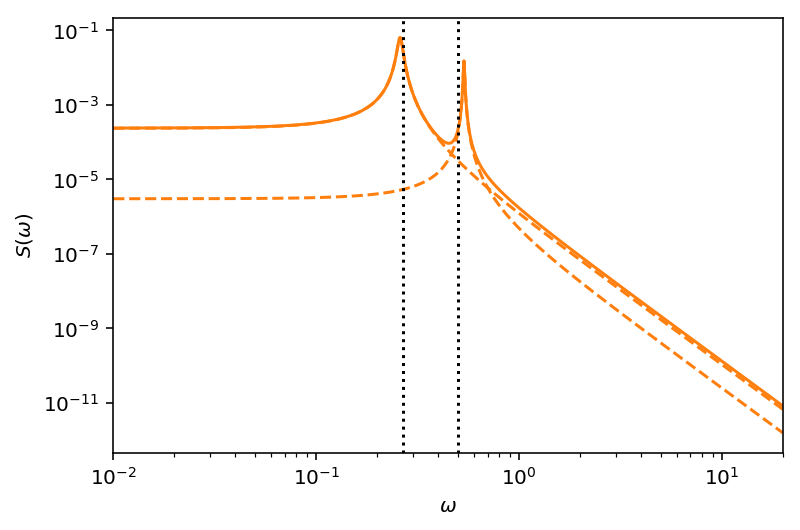

In [23]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')
plt.axvline(2.0*np.pi/12.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

## Now let's apply to the ASASSN data!

In [24]:
df_ASASSN = df_ASASSN.sort_values('time').reset_index(drop=True)

In [25]:
t = df_ASASSN.time.values
y = df_ASASSN.flux
yerr = df_ASASSN.flux_err

<ErrorbarContainer object of 3 artists>

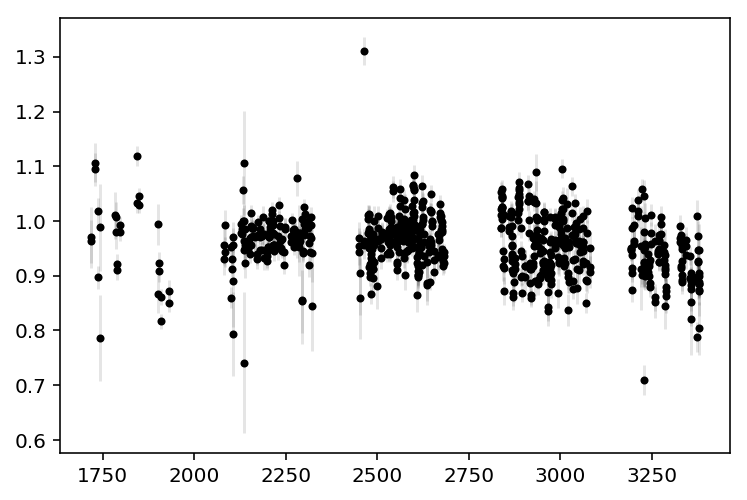

In [26]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)


In [27]:
gp.get_parameter_vector()

array([-12.48283183,  -0.62458243,  -8.1265637 ,   2.80414327,
        -1.34893437])

In [28]:
# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [29]:
%%time
gp2 = celerite.GP(kernel, mean=np.mean(y))
gp2.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y)))

Initial log likelihood: 1014.773382604715
CPU times: user 1.21 ms, sys: 229 µs, total: 1.44 ms
Wall time: 1.27 ms


Text(0, 0.5, 'y')

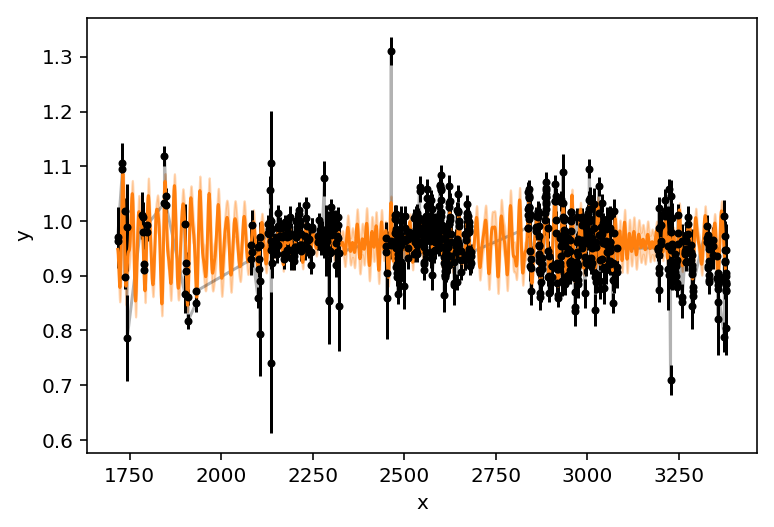

In [30]:
x = np.arange(df_ASASSN.time.iloc[0], df_ASASSN.time.iloc[-1], 1.0/2.0) # HALF DAY SAMPLING!
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

Let's transfer the GP parameters from K2:

In [31]:
gp2.set_parameter_vector(gp.get_parameter_vector())

CPU times: user 3.58 s, sys: 437 ms, total: 4.02 s
Wall time: 2.8 s


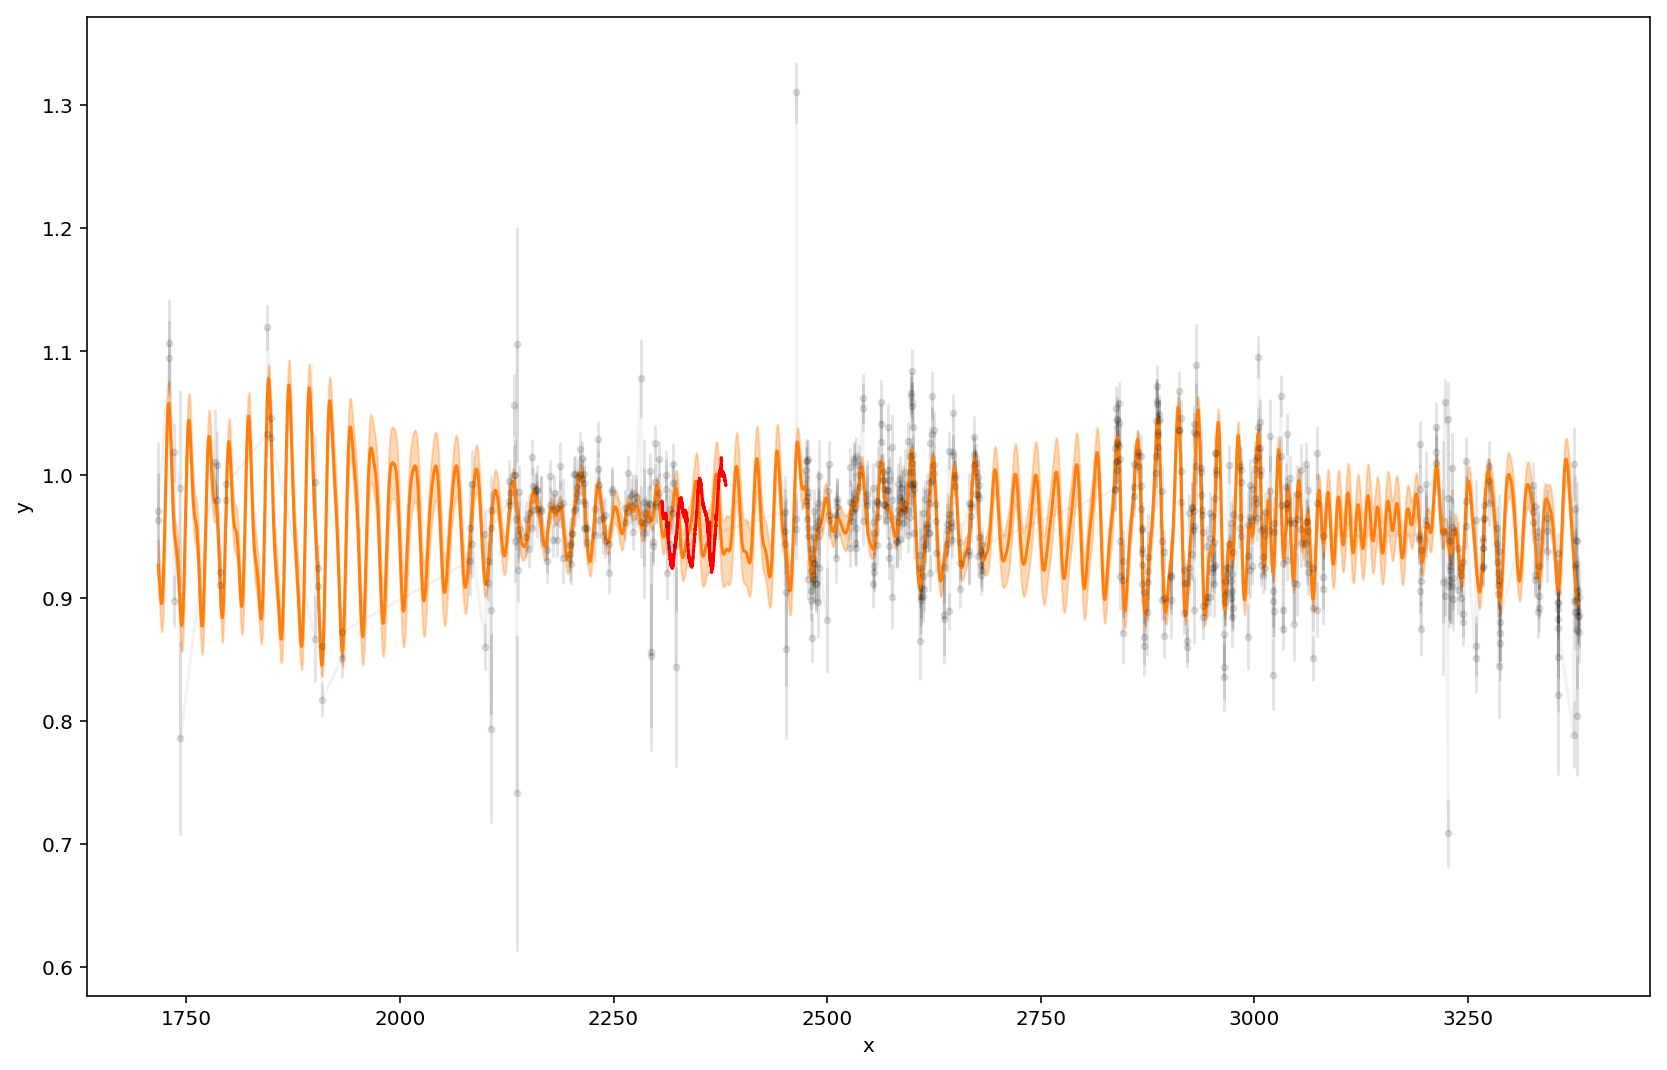

In [38]:
%%time
plt.figure(figsize=(14, 9))
x = np.arange(df_ASASSN.time.iloc[0], df_ASASSN.time.iloc[-1], 1.0/2.0) #half-day sampling
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_mean_K2, pred_var_K2 = gp.predict(df.flux.values, x, return_var=True)
pred_std = np.sqrt(pred_var)
pred_std_K2 = np.sqrt(pred_var_K2)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

CPU times: user 34.2 ms, sys: 2.7 ms, total: 36.9 ms
Wall time: 34.4 ms


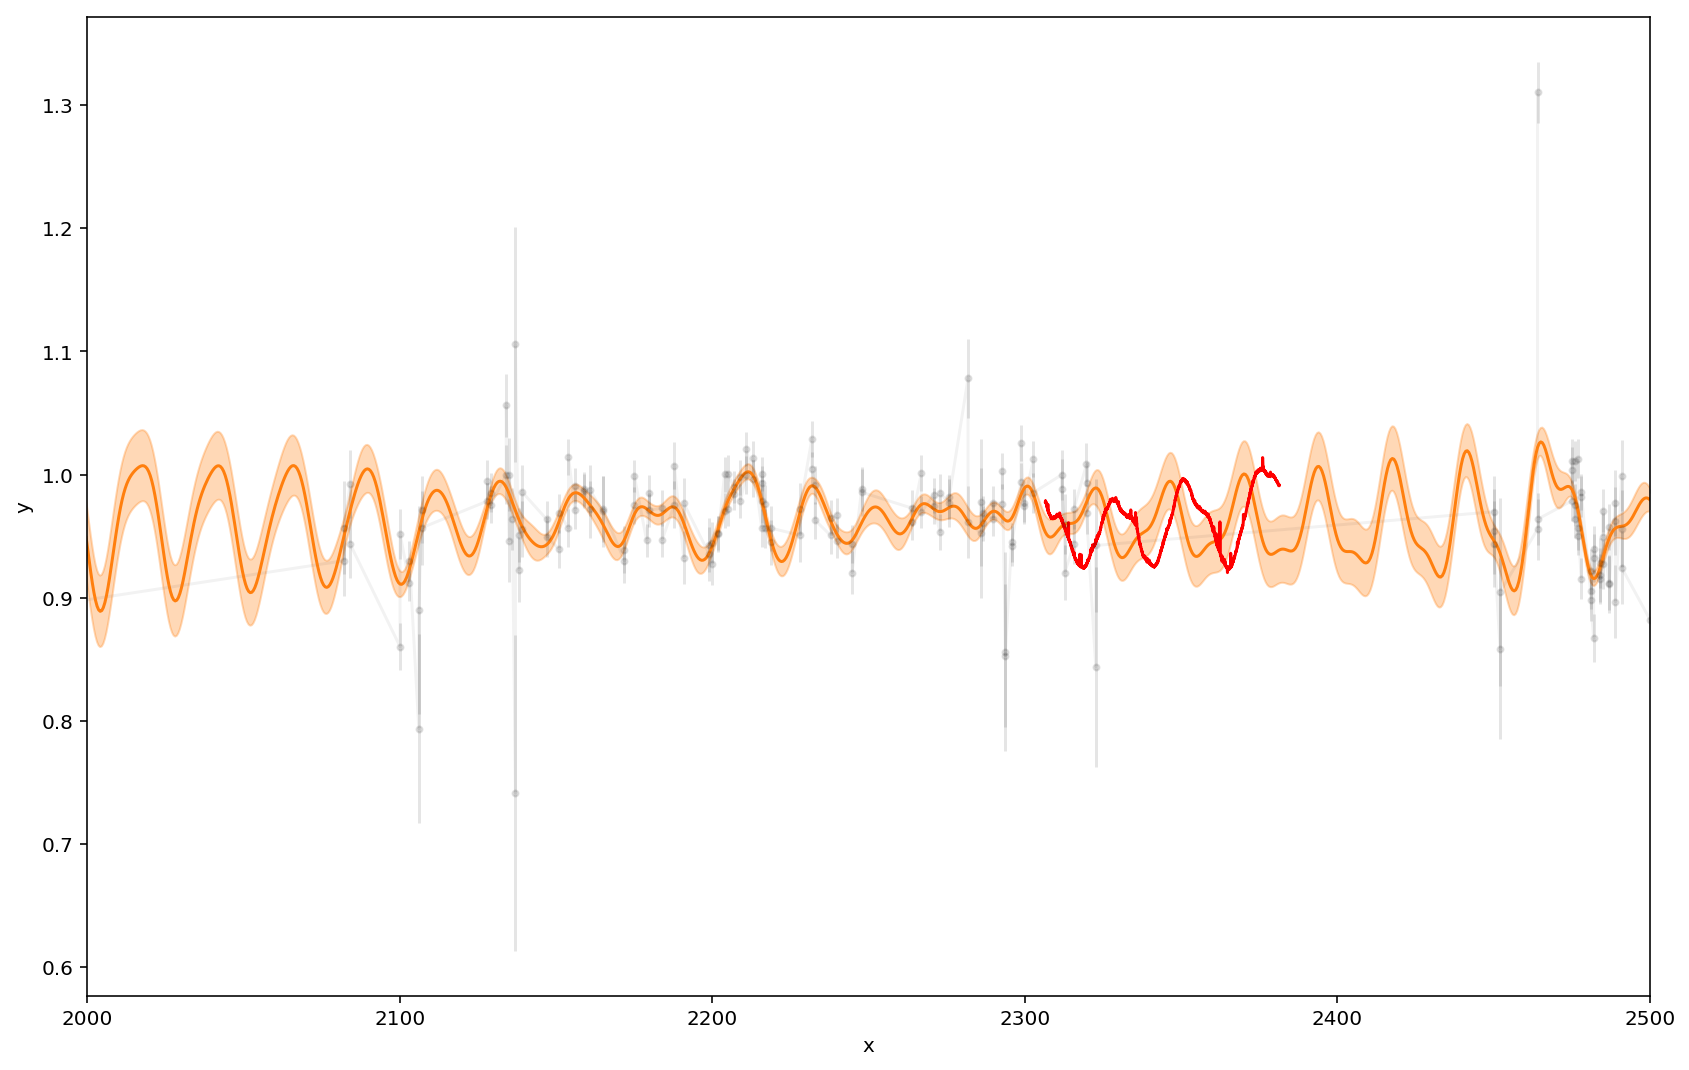

In [39]:
%%time
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(2000, 2500)

CPU times: user 123 ms, sys: 14 ms, total: 137 ms
Wall time: 135 ms


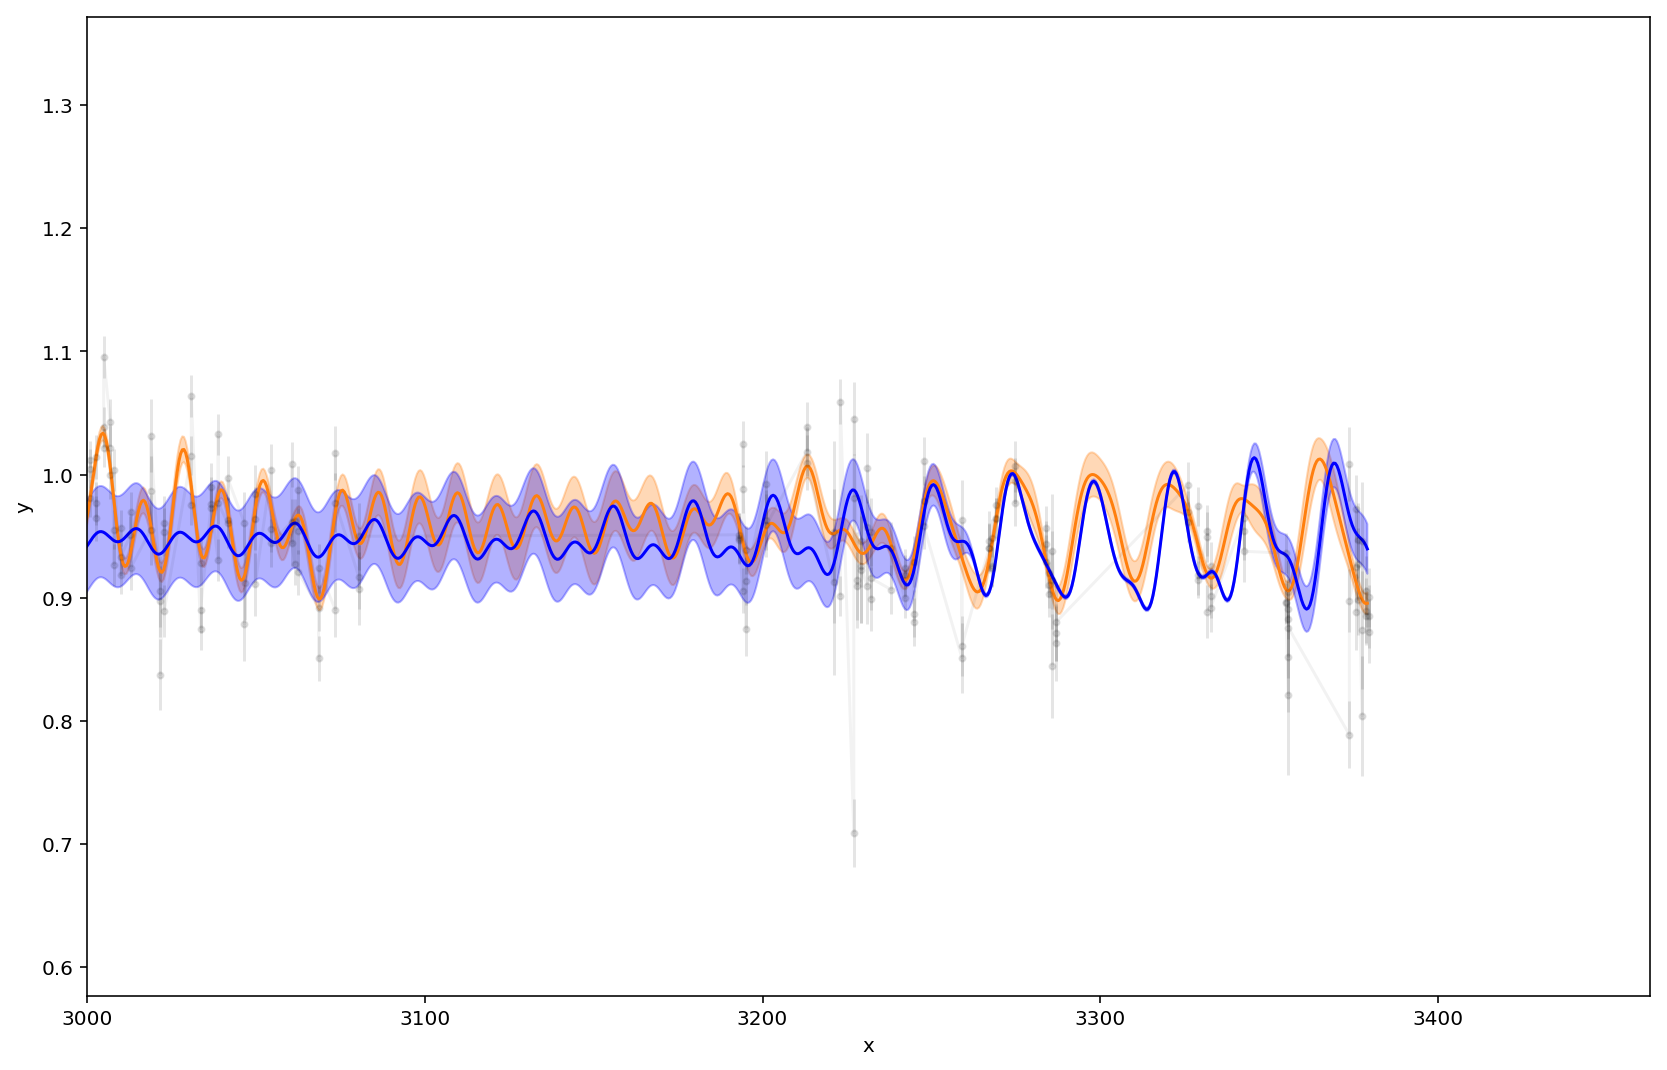

In [40]:
%%time
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(3000)